This notebook constructs the first few figures in Andrei, Mann, and Moyen (2019) relating aggregate investment to Tobin's Q, using the same vintage of data that we downloaded and archived at the time. The algorithm that we followed mimicked Hall (2001) as closely as possible.

There are two companion notebooks to this one:

**AMM2019 - FRED API data.ipynb** follows the same algorithm, but downloads the data directly from FRED via API, instead of importing our archived data files. This results in code that can be dynamically updated over time, reflecting both newer data releases and revisions to historical figures. Due to revisions, the results of this code will not exactly match our published paper.

**AMM2019 - FRED API data - simplified.ipynb** then shows that our qualitative conclusions can be seen with a much simpler approach that skips over many of the steps from Hall (2001) and focuses attention on the most important patterns in the data. This simplified approach is also closer in spirit to most analysis with Compustat data, which typically does not attempt to adjust for inflation or the difference between book values and market values of debt.

# Import packages

In [1]:
import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import math
import re

# Import data

## BEA data on fixed assets, nonfarm inventories, and price deflators

This is a general algorithm for importing data from the BEA spreadsheets.

In [2]:
def process_BEA_xls(file_path, sheet_name, cell_range, rename_column, start_index,time):
    [[firstcol,firstrow],[lastcol,lastrow]] = [re.findall(r'[A-Z]+|\d+',x) for x in str.split(cell_range,":")]
    firstrow = int(firstrow)
    lastrow = int(lastrow)
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=None, 
                       skiprows=firstrow-1,nrows=lastrow-firstrow+1,
                       usecols=firstcol+":"+lastcol).T.reset_index(drop=True)
    df.rename(columns={0: rename_column}, inplace=True)
    if time == "year":
        years = pd.PeriodIndex(df.index.to_numpy(dtype="int64") + start_index + 1, freq="Y")
        df.index = years
        return df[rename_column]
    if time == "quarter":
        base = pd.Period("1960Q1", freq="Q")
        quarters = base + (df.index.to_numpy(dtype="int64") + start_index + 1)
        df.index = pd.PeriodIndex(quarters, freq="Q")
        return df[rename_column]

### Fixed asset accounts: 
These describe stocks and depreciation of fixed assets.

- The underlying data series are located at http://apps.bea.gov//national/FA2004/SS_Data/Section1All_xls.xls
- The download site with this link is http://apps.bea.gov//national/FA2004/DownSS2.asp
- The version that we downloaded is dated 8/22/2017 according to the first sheet.

*Aggregate annual current-cost net-stock of private nonresidential fixed assets.*

- Row 4 of Table 1.1 in the spreadsheet mentioned above.
- The same series is reported at http://fred.stlouisfed.org/series/K1NTOTL1ES000

In [3]:
net_capital = process_BEA_xls('../Data/BEA/Section1All_xls.xls', '101 Ann', "D13:CQ13", 'net_capital', 1924,"year")

*Aggregate annual current-cost net-stock of private nonresidential fixed IP assets.*

- Row 7 of Table 1.1 of the spreadsheet linked above.
- The same series is also recorded at https://fred.stlouisfed.org/series/K1NTOTL1IP000
- This series was added to the fixed assets series in 2013. It can be useful for reconciling with pre-2013 analysis, though we do not pursue that here.

In [4]:
IP_capital = process_BEA_xls('../Data/BEA/Section1All_xls.xls', '101 Ann', "D16:CQ16", 'net_IP_capital', 1924,"year")

### NIPA tables: 
These cover investment, inventories, and price deflators.

- We downloaded the data in this section from the BEA website on September 27, 2017.
- At that time, it was divided across two sheets named Section5ALL_Hist.xls (1947-1969) and Section5all_xls.xls (1969-present).
- Since then, the data have been combined into a single spreadsheet located at http://apps.bea.gov/national/Release/XLS/Survey/Section5All_xls.xlsx and are also available for download through the Fred API using the mnemonics listed below.

*Aggregate quarterly private nonresidential fixed investment (seasonally adjusted at annual rates):*

- 1947-1969 is in Row 2 of Table 5.3.5 (quarterly) in the spreadsheet Section5ALL_Hist.xls
- 1969-2017 is in Row 2 of Table 5.3.5 (quarterly) in the spreadsheet Section5all_xls.xls
- The same series is also recorded at http://fred.stlouisfed.org/series/PNFI

In [5]:
PNFI_1969_2015 = process_BEA_xls('../Data/BEA/Section5all_xls.xls', '50305 Qtr', "D11:GO11", 'PNFI', 35,"quarter")
PNFI_1947_1969 = process_BEA_xls('../Data/BEA/Section5ALL_Hist.xls', '50305 Qtr', "D11:CQ11", 'PNFI', -53,"quarter")
PNFI = pd.concat([PNFI_1947_1969,PNFI_1969_2015['1970':]])

*Quarterly spending on intellectual property products:*

- As mentioned above, this category was added to the fixed assets data in 2013.

In [6]:
PNFI_IP_1947_1969 = process_BEA_xls('../Data/BEA/Section5ALL_Hist.xls', '50305 Qtr', "D25:CQ25", 'PNFI_IP', -53,"quarter")
PNFI_IP_1969_2015 = process_BEA_xls('../Data/BEA/Section5all_xls.xls', '50305 Qtr', "D25:GO25", 'PNFI_IP', 35,"quarter")
PNFI_IP = pd.concat([PNFI_IP_1947_1969,PNFI_IP_1969_2015['1970':]])

*Aggregate private nonfarm inventories (seasonally adjusted at annual rates):*

- 1947-1969 is in Row 3 of Table 5.8.5A (quarterly) in the spreadsheet Section5ALL_Hist.xls
- 1969-1997 is in Row 3 of Table 5.8.5A (quarterly) in the spreadsheet Section5all_xls.xls
- 1997-2017 is in Row 3 of Table 5.8.5B (quarterly) in the spreadsheet Section5all_xls.xls
- The spreadsheet reports this figure in billions, so in the last step below we adjust to millions to be consistent with all the other data series we use.

In [7]:
Inventories_1947_1969 = process_BEA_xls('../Data/BEA/Section5ALL_Hist.xls','50805A Qtr',"D12:CQ12",'inventories',-53,"quarter")
Inventories_1969_1997 = process_BEA_xls('../Data/BEA/Section5all_xls.xls','50805A Qtr',"D12:DO12",'inventories',35,"quarter")
Inventories_1997_2015 = process_BEA_xls('../Data/BEA/Section5all_xls.xls','50805B Qtr',"G29:CK29",'inventories',146,"quarter")
Inventories = pd.concat([Inventories_1947_1969,Inventories_1969_1997['1970':'1996'],Inventories_1997_2015['1997':]])
Inventories = 1000*Inventories

*Price index for private nonresidential fixed investment:*

- 1947-1969 is in Row 2 of Table 5.3.4 (quarterly) in the spreadsheet Section5ALL_Hist.xls
- 1969-2017 is in Row 2 of Table 5.3.4 (quarterly) in the spreadsheet Section5all_xls.xls
- Note that the sheets we downloaded are indexed to 2009, but in more recent updates the base year has changed.

In [8]:
nipa_investment_deflator_1969_2015 = process_BEA_xls('../Data/BEA/Section5all_xls.xls', '50304 Qtr', "D11:GO11", 'nipa_investment_deflator', 35, "quarter")
nipa_investment_deflator_1947_1969 = process_BEA_xls('../Data/BEA/Section5ALL_Hist.xls', '50304 Qtr', "D11:CQ11", 'nipa_investment_deflator', -53, "quarter")
nipa_investment_deflator = pd.concat([nipa_investment_deflator_1947_1969,nipa_investment_deflator_1969_2015['1970':]])
Deflator = nipa_investment_deflator / 100

## Federal Reserve data on nonfinancial corporate investment, assets, and liabilities, and yields on tax-exempt bonds.

### Fed Flow of Funds data on investment, assets, and liabilities of US nonfinancial corporate businesses.

- FL = Levels; FU = Unadjusted flows; FA = Seasonally-adjusted flows at annual rates (must divide by 4)
- Information about these prefixes is provided at http://www.federalreserve.gov/apps/fof/SeriesStructure.aspx
- We downloaded the data on Sep 27, 2017 from the Data Download Program at http://www.federalreserve.gov/datadownload/Choose.aspx?rel=Z1
- They can also be downloaded from FRED using the mnemonics listed after each series.

In [9]:
FRB_Z1_data = pd.read_csv('../Data/FRB/FRB_Z1.csv', skiprows=5)
FRB_Z1_data['quarter'] = pd.PeriodIndex(
    FRB_Z1_data['Time Period'].str.replace(':', ''),
    freq='Q'
)
FRB_Z1_data.set_index('quarter', inplace=True)
FRB_Z1_data = FRB_Z1_data.filter(like='F', axis=1)
# Replace 'ND' with empty and convert to numeric
for column in FRB_Z1_data.columns:
    FRB_Z1_data[column] = pd.to_numeric(FRB_Z1_data[column].replace('ND', ''))

FL103164103Q: Equity liabilities of nonfinancial corporate businesses. http://fred.stlouisfed.org/series/NCBEILQ027S

In [10]:
Equity = FRB_Z1_data['FL103164103.Q']

FL104190005Q: Total liabilities of nonfinancial corporate businesses. http://fred.stlouisfed.org/series/TLBSNNCB


In [11]:
Liabilities = FRB_Z1_data['FL104190005.Q']

FL104090005Q: Total financial assets of nonfinancial corporate businesses http://fred.stlouisfed.org/series/TFAABSNNCB

In [12]:
FinAssets = FRB_Z1_data['FL104090005.Q']

FU105013005Q: Gross fixed investment in nonresidential structures, equipment, and intellectual property products by nonfinancial corporate business. http://fred.stlouisfed.org/series/BOGZ1FU105013005Q

In [13]:
gross_investment = FRB_Z1_data['FU105013005.Q']

FL103163003Q; FA103163003Q: (Taxable) Corporate bonds issued by nonfinancial corporate businesses

- Levels: http://fred.stlouisfed.org/series/CBLBSNNCB
- Issuance: http://fred.stlouisfed.org/series/NCBCBLQ027S

In [14]:
Bonds_issuance_taxable = FRB_Z1_data['FA103163003.Q'] / 4
Bonds_outstanding_taxable = FRB_Z1_data['FL103163003.Q']

FL103162000Q; FA103162000Q: (Tax-exempt) Municipal securities issued by nonfinancial corporate businesses

- Levels: http://fred.stlouisfed.org/series/MSLBSNNCB
- Issuance: http://fred.stlouisfed.org/series/NCBSLLQ027S
- Note that these are tax-exempt bonds issued by corporate businesses, not by municipalities themselves. This typically relates to some sort of private/public partnership. These are a very small asset class in the aggregate.

In [15]:
Bonds_issuance_exempt = FRB_Z1_data['FA103162000.Q'] / 4
Bonds_outstanding_exempt = FRB_Z1_data['FL103162000.Q']

### FRB H.15: Select interest rates

- Download site: http://www.federalreserve.gov/datadownload/Choose.aspx?rel=H15
- Unique identifier is H15/discontinued/RIBLGNG20_N.M
- Click on "Build Package", select "Discontinued series from the H.15";  "SL - State & Local Bonds"; "Y20", "Monthly"
- We downloaded this data on September 29, 2017.

In [16]:
FRB_H15_data = pd.read_csv('../Data/FRB/FRB_H15_SL.csv', skiprows=5, nrows=765, usecols=[0, 1])
FRB_H15_data['month'] = pd.to_datetime(FRB_H15_data['Time Period']).dt.to_period('M')
FRB_H15_data['quarter'] = pd.to_datetime(FRB_H15_data['Time Period']).dt.to_period('Q')

RIBLGNG20_N: The Bond Buyer Go 20-Bond Municipal Bond Index, an index of muni bond yields that was used in Hall (2001) to measure the yield on tax-exempt bonds. https://fred.stlouisfed.org/series/WSLB20

- The index was discontinued after 2016. This does not affect the analysis in our published paper because our sample ended in 2015. To extend the analysis to more recent years, a decent proxy for the GO 20 is 0.7 times the Moody's taxable bond yield (see below). 
- Ultimately tax-exempt bonds issued by corporations are a very small fraction of the aggregate financial assets being measured in Tobin's Q, so the decisions made here have essentially no impact on the analysis.

In [17]:
FRB_H15_data.rename(columns={'RIBLGNG20_N.M':'yield_exempt'},inplace=True)
FRB_H15_data['yield_exempt'] = FRB_H15_data['yield_exempt']
# Keep only the first observation for each quarter
FRB_H15_data.sort_values(by=['quarter', 'month'], inplace=True)
FRB_H15_data.drop_duplicates(subset='quarter', keep='first', inplace=True)
FRB_H15_data.drop('month',axis=1,inplace=True)
FRB_H15_data.set_index('quarter',inplace=True)
yield_exempt = FRB_H15_data['yield_exempt']

**Erratum 1**: We omitted the next line in our published analysis. Comment it to match the figures in the published paper. Uncomment it for an approach that is conceptually more appropriate. This has negligible impact on the results.

In [18]:
yield_exempt = yield_exempt / 100

## Moody's data on corporate bond yields
- We use the reported yield on BAA bonds.
- http://fred.stlouisfed.org/series/BAA
- Downloaded from FRED on September 29, 2017.

In [19]:
Moodys_BAA_data = pd.read_excel('../Data/Moodys/BAA.xls', skiprows=11, usecols=[0, 1], names=['date', 'yield_taxable'])
Moodys_BAA_data['quarter'] = pd.to_datetime(Moodys_BAA_data['date']).dt.to_period('Q')
Moodys_BAA_data['yield_taxable'] = Moodys_BAA_data['yield_taxable'] / 100
# Keep only the first observation for each quarter
Moodys_BAA_data.sort_values(by=['quarter', 'date'], inplace=True)
Moodys_BAA_data.drop_duplicates(subset='quarter', keep='first', inplace=True)
Moodys_BAA_data.set_index('quarter',inplace=True)
yield_taxable = Moodys_BAA_data['yield_taxable']

# Process data to construct investment rate and Tobin's Q

## Hall (2001) algorithm for approximating the market value of outstanding bonds:

- Assume all bonds are issued at par with a ten year lifespan, one coupon each four quarters, and YTM equal to the BAA index for taxable bonds or the BBI Go 20 index for tax-exempt.
- Each quarter, the gross amount of debt issued in this manner is this quarter's recorded net issuance, plus any net issuance ten years ago (40 quarters ago). To see why we add them together, imagine that the maturing debt from ten years ago was simply paid off. Then net issuance today would be exactly the negative of net issuance ten years ago and gross is zero.
- The associated coupon is today's gross issuance times today's prevailing yield.
- Finally, for any given quarter, we project the *future* cash flows from the corporate sector to investors associated with the *existing* stock of debt at this quarter. These cash flows will be the sum of coupons and principal repayments on past issuance. Since we assume a ten-year maturity on all debt, at any moment we have only 40 future quarters to consider.
- Discount all cash flows projected during those 40 quarters at today's prevailing yield. The result of that DCF is today's market value of bonds outstanding.

Apply the above algorithm for **taxable** corporate bonds:

In [20]:
# Calculate gross issuance during any quarter
Bonds_issuance_taxable_gross = Bonds_issuance_taxable + Bonds_issuance_taxable.shift(40).fillna(0)
# Coupon associated with each quarter's gross issuance, will apply to the next 40 quarters
Coupon_issued_taxable = yield_taxable*Bonds_issuance_taxable_gross
# Create an empty dataframe to hold the cash flows over the next 40 quarters starting from any date
Cashflows_taxable = pd.DataFrame(index = Coupon_issued_taxable.index)
for future_quarter in range(1,41):
    # Repayment of principal from 40 quarters prior to this future one:
    Cashflows_taxable[future_quarter] = Bonds_issuance_taxable_gross.shift(40-future_quarter).fillna(0)
    # Coupon payments associated with debt from before today, only in increments of 4 quarters:
    for quarterlag in range( 4*math.ceil(future_quarter/4) , 41, 4):
        Cashflows_taxable[future_quarter] += Coupon_issued_taxable.shift(quarterlag-future_quarter).fillna(0)
# Create another dataframe to hold the outcome of all this
Bonds_BV_taxable = Bonds_outstanding_taxable
Bonds_MV_taxable = pd.DataFrame(index = Bonds_BV_taxable.index)
Bonds_MV_taxable['MV'] = 0
for future_quarter in range(1,41):
    Bonds_MV_taxable['MV'] += Cashflows_taxable[future_quarter] / (1+yield_taxable)**(future_quarter/4)
# Convert dataframe back to series
Bonds_MV_taxable = Bonds_MV_taxable['MV']

Apply the above algorithm for **tax-exempt** corporate bonds:

In [21]:
# Calculate gross issuance during any quarter
Bonds_issuance_exempt_gross = Bonds_issuance_exempt + Bonds_issuance_exempt.shift(40).fillna(0)
# Coupon associated with each quarter's gross issuance, will apply to the next 40 quarters
Coupon_issued_exempt = yield_exempt*Bonds_issuance_exempt_gross
# Create an empty dataframe to hold the cash flows over the next 40 quarters starting from any date
Cashflows_exempt = pd.DataFrame(index = Coupon_issued_exempt.index)
for future_quarter in range(1,41):
    # Repayment of principal from 40 quarters prior to this future one:
    Cashflows_exempt[future_quarter] = Bonds_issuance_exempt_gross.shift(40-future_quarter).fillna(0)
    # Coupon payments associated with debt from before today, only in increments of 4 quarters:
    for quarterlag in range( 4*math.ceil(future_quarter/4) , 41, 4):
        Cashflows_exempt[future_quarter] += Coupon_issued_exempt.shift(quarterlag-future_quarter).fillna(0)
Bonds_BV_exempt = Bonds_outstanding_exempt
Bonds_MV_exempt = pd.DataFrame(index = Bonds_BV_exempt.index)
Bonds_MV_exempt['MV'] = 0
for future_quarter in range(1,41):
    Bonds_MV_exempt['MV'] += Cashflows_exempt[future_quarter] / (1+yield_exempt)**(future_quarter/4)
# Convert dataframe back to series
Bonds_MV_exempt = Bonds_MV_exempt['MV']

## Calculate investment and investment rate, enterprise value, and Q. 

Calculate aggregate enterprise value of nonfinancial corporate business (the numerator of Tobin's Q).

In [22]:
EnterpriseValue = Equity + Liabilities - FinAssets - Inventories + (Bonds_MV_taxable - Bonds_BV_taxable) + (Bonds_MV_exempt - Bonds_BV_exempt)

Deflate investment, enterprise value, and end-of-year net capital stock to real values.

In [23]:
PNFI_real = PNFI / Deflator
EnterpriseValue_real = EnterpriseValue / Deflator

For the denominator of the investment rate, Hall uses the BEA's current-cost net stock of private nonresidential fixed assets, which we imported above. This number is only reported at the end of each year, so interpolate it linearly to the other three quarters of each year.

In [24]:
net_capital_real = net_capital / Deflator.resample('Y').last()
net_capital_real_smooth = net_capital_real.resample('Q').interpolate().shift(3)

**Erratum #2**: Our algorithm for the above step in the published paper contained an error. Let the next code block run to match exactly the numbers reported in the paper. Comment it to use the above approach, which is conceptually more appropriate. This has negligible impact on the results.

In [25]:
# net_capital_real = net_capital.resample('Q').ffill() / Deflator
# net_capital_real_aux = net_capital_real.resample('Y').last().resample('Q').ffill().shift(3)
# net_capital_real_smooth = net_capital_real.copy()
# net_capital_real_smooth[net_capital_real_smooth.index.quarter == 1] = 0.25*net_capital_real_smooth + 0.75*net_capital_real_aux
# net_capital_real_smooth[net_capital_real_smooth.index.quarter == 2] = 0.50*net_capital_real_smooth + 0.50*net_capital_real_aux
# net_capital_real_smooth[net_capital_real_smooth.index.quarter == 3] = 0.75*net_capital_real_smooth + 0.25*net_capital_real_aux

For the denominator of Tobin's Q, Hall calculates a different capital stock by starting with the BEA's net capital stock for 1951, then accumulating the investment figures reported in the Flow of Funds data, and depreciating them at an annualized rate of 10%. All these quantities are first deflated with the same NIPA investment deflator as elsewhere in the analysis.

In [26]:
annual_depreciation = 0.1
quarterly_depreciation = 1-(1-0.1)**(0.25)
real_investment = gross_investment / Deflator
replacement_cost = net_capital_real_smooth.copy()
replacement_cost[:] = math.nan
replacement_cost.loc['1951Q4'] = net_capital_real_smooth.loc['1951Q4']
for indexval in replacement_cost['1952Q1':'2016Q4'].index:
    replacement_cost.loc[indexval] = (1-quarterly_depreciation)*replacement_cost.loc[indexval-1] + real_investment.loc[indexval]

Calculate investment rate and Tobin's Q.

- Investment rate is investment during a quarter divided by stock of capital from the end of last quarter.
- Tobin's Q is enterprise value at the end of a quarter divided by capital stock at the end of the quarter.
- Due to this timing, in our analysis we compare the investment rate for a given quarter with *lagged* Tobin's Q.

In [27]:
ik = PNFI_real / net_capital_real_smooth.shift()
Q = EnterpriseValue_real / replacement_cost

## Figures 1 and 2 from the published paper

Figure 1: Investment and lagged Q in levels

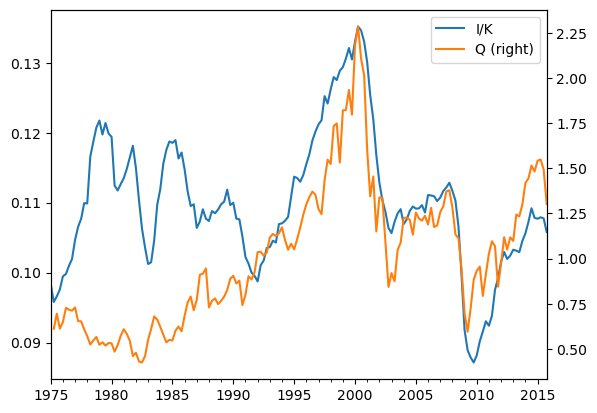

In [28]:
ik['1975Q1':'2015Q4'].plot(legend=True,label="I/K");
Q['1975Q1':'2015Q4'].shift().plot(legend=True,label="Q",secondary_y=True);

$R^2$ values reported in Figure 1 of the published paper:

In [29]:
R2_early = ols("ik~Q.shift()",
               data=pd.concat([ik.rename("ik"),Q.rename("Q")],axis=1)['1974Q4':'1995Q4']
              ).fit().rsquared
print("R2 for 1975-1995: " + '%2.2f' % (100*R2_early) + '%')

R2_late = ols("ik~Q.shift()",
               data=pd.concat([ik.rename("ik"),Q.rename("Q")],axis=1)['1994Q4':'2015Q4']
              ).fit().rsquared
print("R2 for 1995-2015: " + '%2.2f' % (100*R2_late) + '%')

R2 for 1975-1995: 10.11%
R2 for 1995-2015: 71.91%


Figure 2: Investment and lagged Q as year-over-year differences

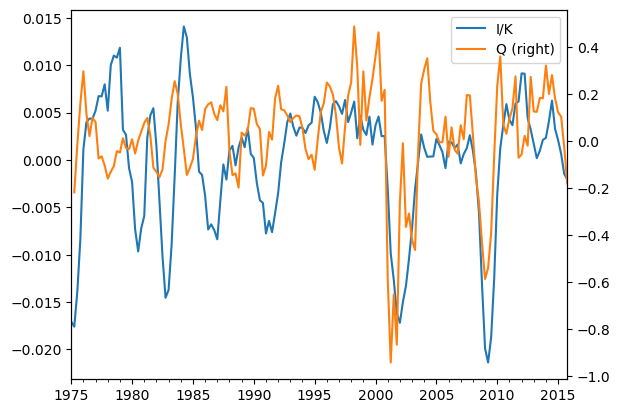

In [30]:
ik.diff(4)['1975Q1':'2015Q4'].plot(legend=True,label="I/K");
Q.diff(4)['1975Q1':'2015Q4'].shift().plot(legend=True,label="Q",secondary_y=True);

$\sigma_q$ and $R^2$ values reported in Figure 2 of the published paper:

In [31]:
SDQ_early = Q.diff(4).shift()['1975Q1':'1995Q4'].std()
R2_early = ols("ik.diff(4)~Q.diff(4).shift()",
               data=pd.concat([ik.rename("ik"),Q.rename("Q")],axis=1)['1973Q4':'1995Q4']
              ).fit().rsquared
print("R2 for 1975-1995: " + '%2.2f' % (100*R2_early) + '%')
print("SD(Δ4 Q) for 1975-1995: " + '%2.2f' % (100*SDQ_early) + '%')

print('\n')

SDQ_late = Q.diff(4).shift()['1995Q1':'2015Q4'].std()
R2_late = ols("ik.diff(4)~Q.diff(4).shift()",
               data=pd.concat([ik.rename("ik"),Q.rename("Q")],axis=1)['1993Q4':'2015Q4']
              ).fit().rsquared
print("R2 for 1995-2015: " + '%2.2f' % (100*R2_late) + '%')
print("SD(Δ4 Q) for 1995-2015: " + '%2.2f' % (100*SDQ_late) + '%')

R2 for 1975-1995: 0.02%
SD(Δ4 Q) for 1975-1995: 13.12%


R2 for 1995-2015: 50.27%
SD(Δ4 Q) for 1995-2015: 28.26%
